# Image Coloring Problem
In this project, you will tackle the challenge of image colorization, a process that involves adding color to grayscale images. Image colorization has applications in various fields, such as restoring old movies and photographs, enhancing satellite imagery, and assisting in medical image analysis.

The goal is to build a deep learning model that can accurately predict the color channels of an image given its grayscale version. You will use PyTorch, a popular deep learning library, to construct and train your model. The project will be structured around several key tasks, each contributing to the development and evaluation of your colorization model.

# U-Net Architecture

The neural network
The neural network needs to take in a noised image at a particular time step and return the predicted noise. Note that the predicted noise is a tensor that has the same size/resolution as the input image. So technically, the network takes in and outputs tensors of the same shape. What type of neural network can we use for this?

What is typically used here is very similar to that of an Autoencoder, which you may remember from typical "intro to deep learning" tutorials. Autoencoders have a so-called "bottleneck" layer in between the encoder and decoder. The encoder first encodes an image into a smaller hidden representation called the "bottleneck", and the decoder then decodes that hidden representation back into an actual image. This forces the network to only keep the most important information in the bottleneck layer.

In terms of architecture, the DDPM authors went for a U-Net, introduced by (Ronneberger et al., 2015) (which, at the time, achieved state-of-the-art results for medical image segmentation). This network, like any autoencoder, consists of a bottleneck in the middle that makes sure the network learns only the most important information. Importantly, it introduced residual connections between the encoder and decoder, greatly improving gradient flow (inspired by ResNet in He et al., 2015).

Here's a description of the UNet architecture:

**1. Contracting Path (Encoder):**

- The input to the UNet is typically a grayscale or multi-channel image.
- The contracting path starts with a series of convolutional layers followed by max-pooling layers.
- Each convolutional layer is usually followed by a rectified linear unit (ReLU) activation function.
- The number of filters typically increases with the depth of the network, capturing increasingly abstract features.
- Max-pooling layers progressively downsample the spatial dimensions of the feature maps, allowing the network to learn hierarchical representations.

**2. Bottleneck:**

- At the bottom of the U-shaped architecture lies the bottleneck or central layer.
- It represents the point where the network switches from the contracting path to the expanding path.
- The bottleneck layer typically consists of convolutional layers without max-pooling, allowing the network to capture contextual information.

**3. Expanding Path (Decoder):**

- The expanding path involves upsampling the feature maps and concatenating them with feature maps from the contracting path.
- Each step in the expanding path involves an upsampling operation (e.g., transposed convolution or upsampling followed by convolution) to increase the spatial resolution.
- The concatenated feature maps from the corresponding contracting path stage serve as skip connections.
- Skip connections help preserve spatial information and assist in the precise localization of segmentation boundaries.

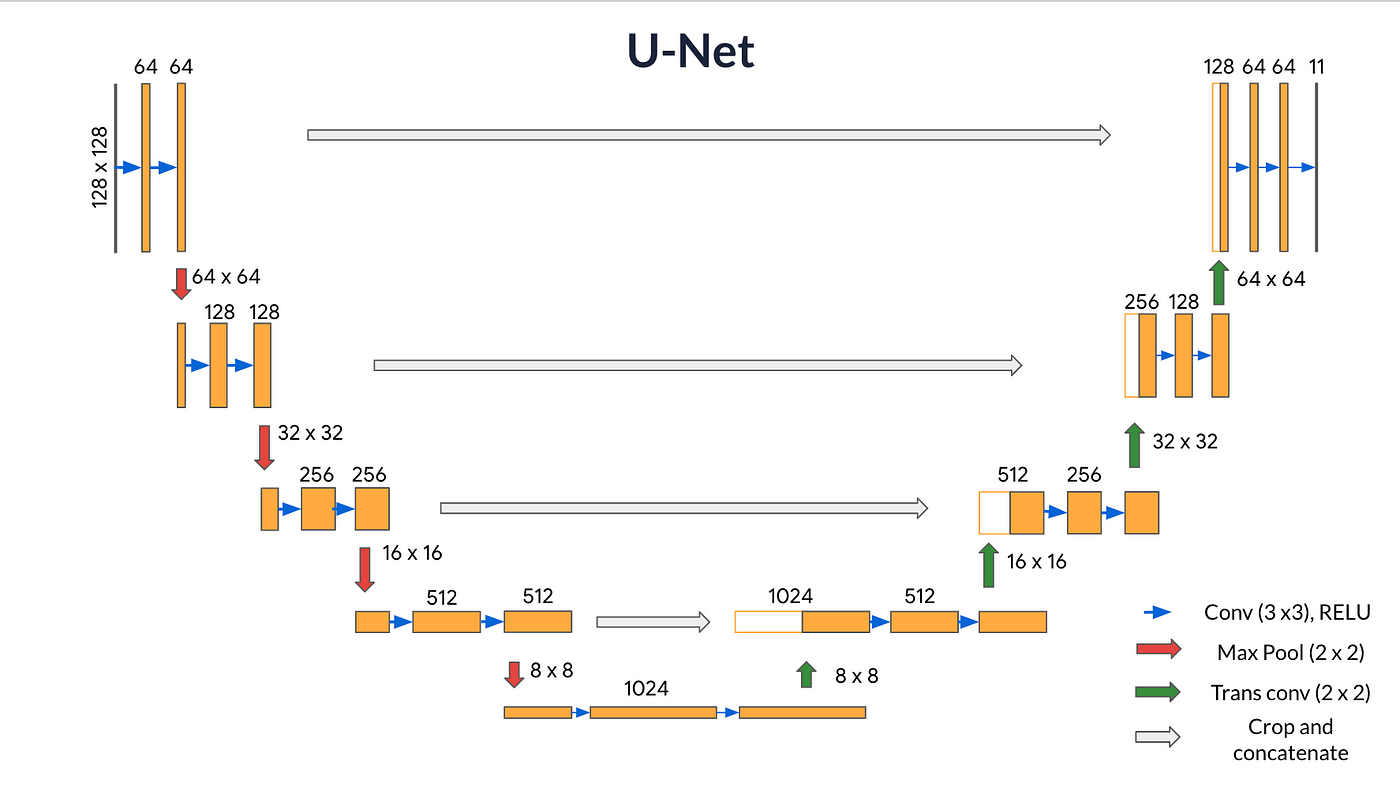
This was adapted from Lukman Aliyu




## Requirements
- Prepare the data
- Build a U-net architecture
- Train the model on the prepared dataset
- Display 5 images from the training set in 3 formats: original color, grayscale, and the colorized
- Run inference on 10 images in the test set
- Display the 10 images in 3 formats: original color, grayscale, and the colorized

# 1. Setup and Imports

In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import torch.nn.functional as F
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.models import vgg16

# 2. Load the Dataset (2 points)

In [ ]:
# Transformations for the input images (grayscale)
transform_input = transforms.Compose([
    #--------------------------------- # Convert to grayscale
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1),

])

# Transformations for the target images (color)
transform_target = transforms.Compose([
    transforms.ToTensor(),
])

# Custom dataset class
class ColorizationDataset(Dataset):
    def __init__(self, dataset, transform_input=None, transform_target=None):
        self.dataset = dataset
        self.transform_input = transform_input
        self.transform_target = transform_target

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        input_image, _ = self.dataset[idx]
        target_image = input_image

        if self.transform_input:
            input_image = self.transform_input(input_image)

        if self.transform_target:
            target_image = self.transform_target(target_image)

        return input_image, target_image

# Load CIFAR-10 dataset
train_dataset_full = datasets.CIFAR10(root='./data', train=True, download=True, transform=None)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=None)

# Splitting train dataset into train and validation
# -------------------------------------------------
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset_full, [45000, 5000])

train_dataset = ColorizationDataset(train_dataset, transform_input=transform_input, transform_target=transform_target)
val_dataset = ColorizationDataset(val_dataset, transform_input=transform_input, transform_target=transform_target)
test_dataset = ColorizationDataset(test_dataset, transform_input=transform_input, transform_target=transform_target)

# Apply transformations and create DataLoader for train, validation, and test sets
# -------------------------------------------------
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


100%|██████████| 170498071/170498071 [00:02<00:00, 76683041.67it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# 3. Define the U-Net Model Architecture (3 points)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F.
#There is another code in LABS better

class UNet(nn.Module):  # Unet architecture based
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.middle = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        )

        self.decoder = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),

            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, out_channels, kernel_size=1)
        )

    def forward(self, x):
        x1 = self.encoder(x)
        x2 = self.middle(x1)
        x3 = self.decoder(x2)
        return x3

# Example usage
in_channels = 1  # for GrayScale images (1 channels)
out_channels = 3  # for 3 classes

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = UNet(in_channels, out_channels).to(device)

# 4. Training the Model (2 points + 1 bonus)

## 4.1 Loss function (define custome loss for bonus point)

In [ ]:
#it's fine when you use CrossEntropeLoss()

class ComprehensiveLoss(nn.Module):
    def __init__(self):
        super(ComprehensiveLoss, self).__init__()

    def forward(self, input, target):
        # Calculate the mean squared error between the input and target images
        mse = nn.MSELoss()(input, target)

        # Calculate the mean absolute error between the input and target images
        mae = nn.L1Loss()(input, target)

        # Weight the MSE and MAE losses
        loss = 0.8 * mse + 0.2 * mae

        return loss



In [ ]:
# Loss function and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = ComprehensiveLoss() #it's fine when you use CrossEntropeLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)



# define your scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)




In [ ]:

# Train the model for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # Train the model
    model.train()
    train_loss = 0.0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Evaluate the model
    model.eval()
    val_loss = 0.0
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        val_loss += loss.item()

    # Print the training and validation losses
    print(f'Epoch: {epoch+1}, Train Loss: {train_loss/len(train_loader):.3f}, Val Loss: {val_loss/len(val_loader):.3f}')

    # Update the learning rate
    scheduler.step()


Epoch: 1, Train Loss: 0.067, Val Loss: 0.042
Epoch: 2, Train Loss: 0.041, Val Loss: 0.038
Epoch: 3, Train Loss: 0.037, Val Loss: 0.036
Epoch: 4, Train Loss: 0.035, Val Loss: 0.035
Epoch: 5, Train Loss: 0.034, Val Loss: 0.034
Epoch: 6, Train Loss: 0.033, Val Loss: 0.033
Epoch: 7, Train Loss: 0.032, Val Loss: 0.032
Epoch: 8, Train Loss: 0.031, Val Loss: 0.032
Epoch: 9, Train Loss: 0.031, Val Loss: 0.031
Epoch: 10, Train Loss: 0.030, Val Loss: 0.031


# 5. Showing Performance on Training data (1.5 point)

> Indented block



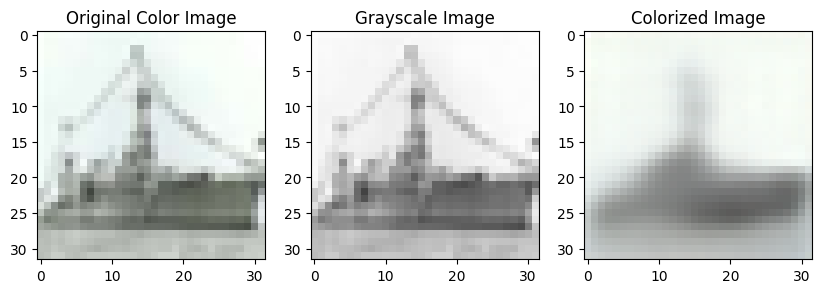

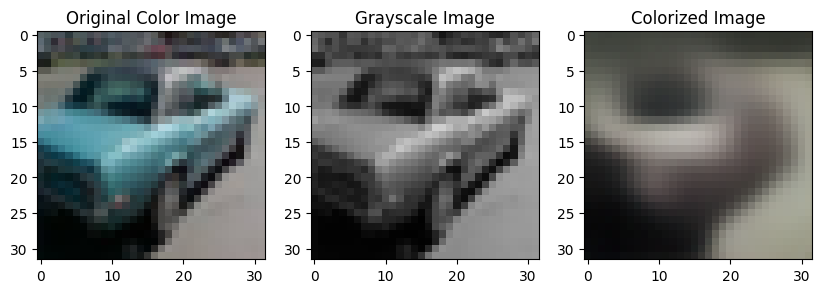

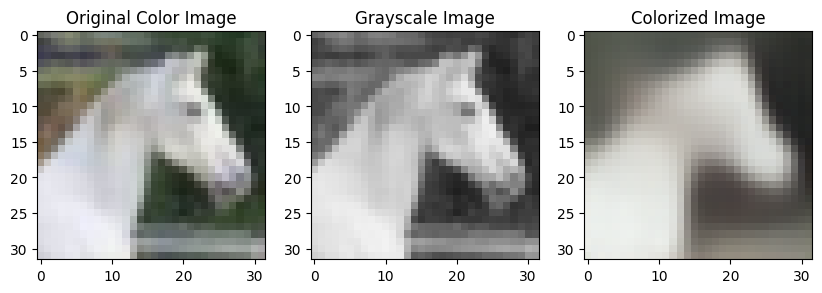

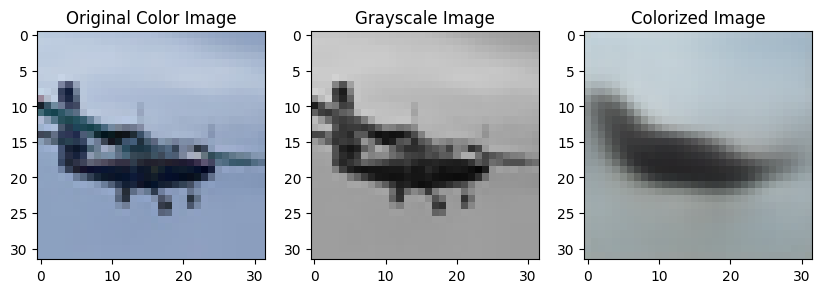

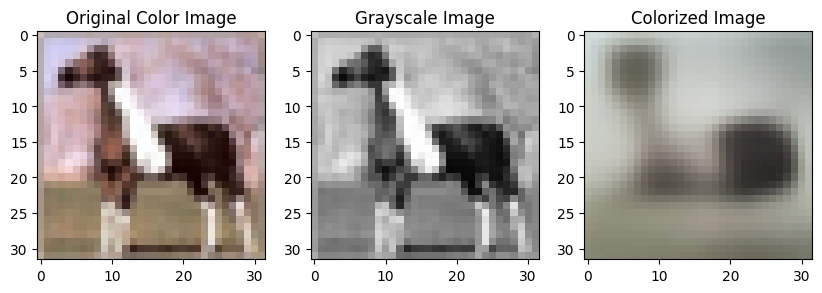

In [ ]:

import matplotlib.pyplot as plt
# Show 5 images from the training set in 3 formats: original color, grayscale, and the colorized

# Get a batch of training data
data, target = next(iter(train_loader))

# Move data to the device
data, target = data.to(device), target.to(device)

# Get the model's prediction
output = model(data)

# Convert the grayscale images to RGB for visualization
data = data.repeat(1, 3, 1, 1)

# Display the images
for i in range(5):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(target[i].cpu().detach().numpy().transpose((1, 2, 0)))
    plt.title('Original Color Image')
    plt.subplot(1, 3, 2)
    plt.imshow(data[i].cpu().detach().numpy().transpose((1, 2, 0)))
    plt.title('Grayscale Image')
    plt.subplot(1, 3, 3)
    plt.imshow(output[i].cpu().detach().numpy().transpose((1, 2, 0)))
    plt.title('Colorized Image')
    plt.show()



# 6. Making Inferences and showing performance on test data (1.5 point)


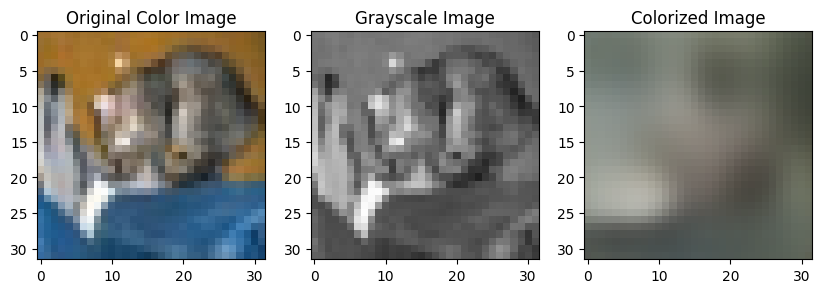

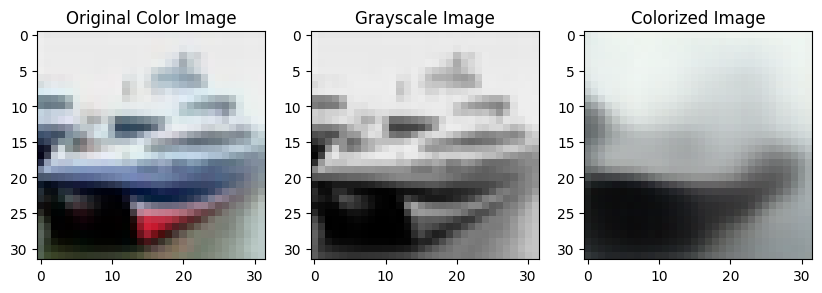

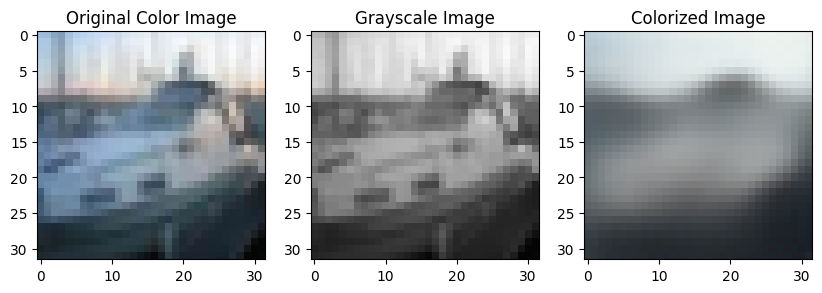

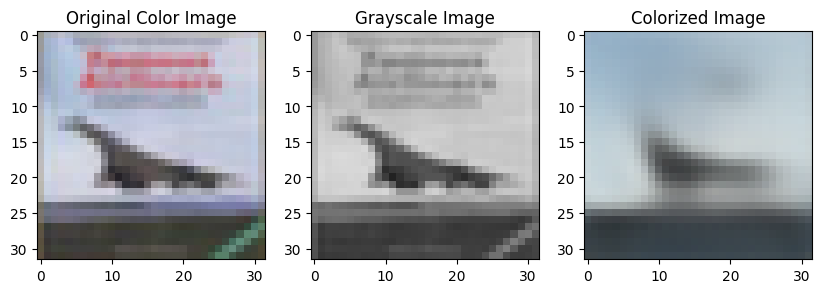

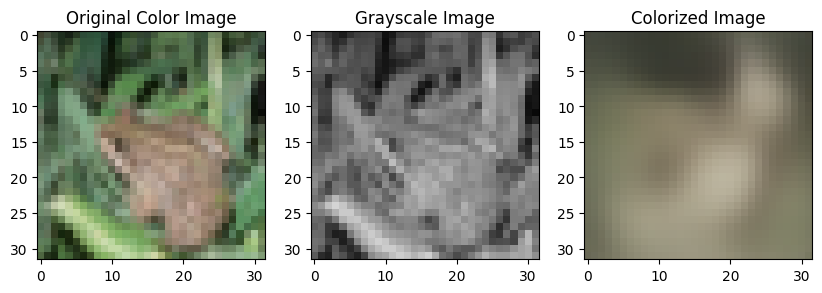

In [ ]:
# Show 5 images from the test set in 3 formats: original color, grayscale, and the colorized

# Get a batch of training data
data, target = next(iter(test_loader))

# Move data to the device
data, target = data.to(device), target.to(device)

# Get the model's prediction
output = model(data)

# Convert the grayscale images to RGB for visualization
data = data.repeat(1, 3, 1, 1)

# Display the images
for i in range(5):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(target[i].cpu().numpy().transpose((1, 2, 0)))
    plt.title('Original Color Image')
    plt.subplot(1, 3, 2)
    plt.imshow(data[i].cpu().numpy().transpose((1, 2, 0)))
    plt.title('Grayscale Image')
    plt.subplot(1, 3, 3)
    plt.imshow(output[i].cpu().detach().numpy().transpose((1, 2, 0)))
    plt.title('Colorized Image')
    plt.show()
